# Clasificación de imágenes de _silkroad2_

El siguiente modelo es una adaptación del [tutorial de TensorFlow de clasificación de imágenes](https://www.tensorflow.org/tutorials/images/classification)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2021-12-19 16:04:19.910427: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-19 16:04:19.910485: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Exploración del dataset

Las imágenes deben estar en carpetas según su categoría.

In [2]:
data_dir = pathlib.Path("../Dataset/silkroad2_images/images_by_tag/")
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Cantidad total de imágenes: {}".format(image_count))

Cantidad total de imágenes: 39670


A modo de ejemplo, alguna foto de anfetaminas:

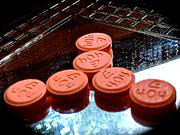

In [3]:
ejemplo = list(data_dir.glob("Amphetamine/*"))[0]
PIL.Image.open(str(ejemplo))

## Cargar datos usando Keras

In [4]:
batch_size = 32
img_height = 135
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [5]:
train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 1,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 40365 files belonging to 301 classes.
Using 32292 files for training.


2021-12-19 16:04:34.918003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-19 16:04:34.918080: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-19 16:04:34.918138: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HUB-Ubuntu): /proc/driver/nvidia/version does not exist
2021-12-19 16:04:34.919148: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
val = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 1,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 40365 files belonging to 301 classes.
Using 8073 files for validation.


In [7]:
class_names = train.class_names
print(class_names)

['2-DPMP', '2-FMA', '25B-NBOMe', '25C-NBOMe', '25D-NBOMe', '25I-NBOMe', '25N-NBOMe', '2C-B', '2C-B-FLY', '2C-C', '2C-D', '2C-E', '2C-Family', '2C-I', '2C-P', '2C-T-2', '2C-T-4', '2C-T-7', '4-ACO-DET', '4-ACO-DMT', '4-ACO-Family', '4-ACO-MIPT', '4-Chlorodehydromethyltestosterone', '4-EMC', '4-FA', '4-FMA', '4-HO-Family', '4-HO-MET', '4-HO-MIPT', '4-HO-MPT', '4-MEC', '5-APB', '5-MAPB', '5-MeO-DALT', '5-MeO-DMT', '5-MeO-DipT', '5-MeO-Family', '5-MeO-MipT', '6-APB', 'A-PVP', 'AH-7921', 'AL-LAD', 'AM-221', 'AMT', 'Accessories', 'Adderall', 'Alcohol', 'Aleph-2', 'Alprazolam', 'Amphetamine', 'Anabolic Steroids', 'Analgesics', 'Antagonists', 'Anti-inflammatory', 'Anti-psychotic', 'Anti-rheumatic', 'Antibiotics', 'Anticancer', 'Anticonvulsant', 'Antidepressant', 'Antihistamine', 'Antiviral', 'Apparel', 'Aranafil', 'Armodafinil', 'Aromatase inhibitors', 'Art', 'Atomexetine', 'Ayahuasca', 'Azurescens', 'Baked goods', 'Barbiturates', 'Benzos', 'Betablockers', 'Biotic materials', 'Black tar', 'Blen

## Visaulización de los datos

Las primeras 9 imágenes del dataset de entrenamiento

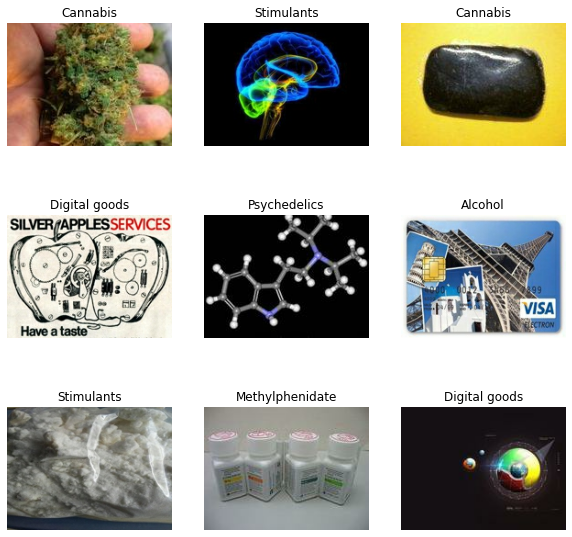

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configuración del rendimiento del dataset

Para asegurarnos un mejor rendimiento, hay que tratar de ir cargando los datos sin que las operaciones de I/O sean bloqueantes. Para esto se utilizan los métodos `Dataset.cache` y `Dataset.prefetch`

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val = val.cache().prefetch(buffer_size = AUTOTUNE)

## Estandarizar los datos

Los canales RGB tienen valores entre 0 y 255. Para las redes neuronales esto no es bueno, hay que estandarizarlos en valores entre 0 y 1

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image)) 

2021-12-19 16:04:50.050812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 42 of 1000
2021-12-19 16:04:59.910431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 67 of 1000
2021-12-19 16:05:10.077581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 92 of 1000
2021-12-19 16:05:19.990023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 124 of 1000
2021-12-19 16:05:29.943499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 156 of 1000
2021-12-19 16:05:39.925886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 193 of 1000
2021-12-19 16:05:49.858989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buff

0.0 1.0


## Creación del modelo

El modelo consistirá de 3 bloques de convolución con un _max pooling_ en cada una de ellas. Al final, habrá una capa _fully-connected_, que es donde más parámetros se encuentran.

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation = 'relu'),
  layers.Dense(num_classes)
])

### Compilación del modelo

In [13]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

### Resumen del modelo

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 135, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 135, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 67, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 33, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 45, 64)        1

## Entrenamiento del modelo

In [15]:
epochs = 10
history = model.fit(train, validation_data = val, epochs = epochs)

Epoch 1/10
1010/1010 [==============================] - 305s 297ms/step - loss: 3.6690 - accuracy: 0.2065 - val_loss: 3.1295 - val_accuracy: 0.2873
Epoch 2/10
1010/1010 [==============================] - 233s 230ms/step - loss: 2.6273 - accuracy: 0.3735 - val_loss: 2.4570 - val_accuracy: 0.4132
Epoch 3/10
1010/1010 [==============================] - 232s 230ms/step - loss: 1.8317 - accuracy: 0.5011 - val_loss: 2.1664 - val_accuracy: 0.4561
Epoch 4/10
1010/1010 [==============================] - 228s 226ms/step - loss: 1.3996 - accuracy: 0.5708 - val_loss: 2.0600 - val_accuracy: 0.4660
Epoch 5/10
1010/1010 [==============================] - 220s 218ms/step - loss: 1.1709 - accuracy: 0.6118 - val_loss: 2.0876 - val_accuracy: 0.4737
Epoch 6/10
1010/1010 [==============================] - 220s 218ms/step - loss: 1.0419 - accuracy: 0.6321 - val_loss: 2.0370 - val_accuracy: 0.4852
Epoch 7/10
1010/1010 [==============================] - 215s 212ms/step - loss: 0.9642 - accuracy: 0.6448 - val_

## Visualización de los resultados

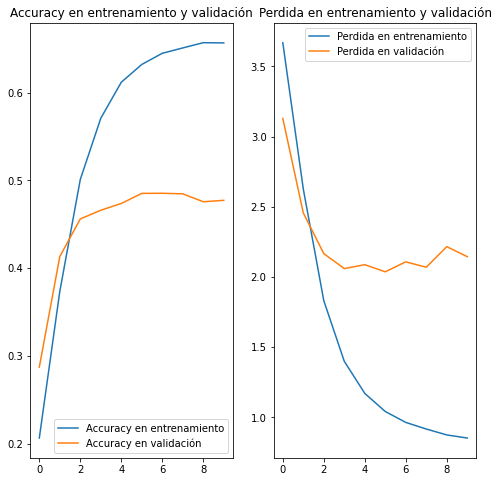

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Accuracy en entrenamiento')
plt.plot(epochs_range, val_acc, label = 'Accuracy en validación')
plt.legend(loc = 'lower right')
plt.title('Accuracy en entrenamiento y validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Perdida en entrenamiento')
plt.plot(epochs_range, val_loss, label = 'Perdida en validación')
plt.legend(loc = 'upper right')
plt.title('Perdida en entrenamiento y validación')
plt.show()

## Overfitting

### Data augmentation

Cuando no disponemos de datos suficientes para entrenar un modelo, se suele generar _Overfitting_. Una posible solución para esto puede ser el _Data augmention_, que consiste en generar nuevas imagenes rotando, girando y volteando las disponibles.

In [17]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Algunos ejemplos de esto:

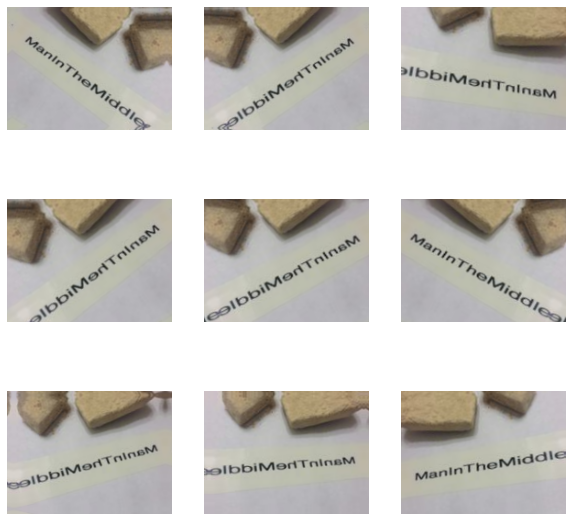

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Dropout

Otra técnica que se utiliza para combatir el _Overfitting_ es el _Dropout_. Este método consiste en deshacerse de la salida de algunas neuronas aleatoriamente durante el entrenamiento.

In [19]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2), #
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## Compilar y entrenar el nuevo modelo

In [20]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 135, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 135, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 135, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 67, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 67, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 33, 45, 32)       0         
 2D)                                                  

In [22]:
history = model.fit(train, validation_data = val, epochs = epochs)

Epoch 1/10
1010/1010 [==============================] - 244s 240ms/step - loss: 3.8851 - accuracy: 0.1674 - val_loss: 3.6524 - val_accuracy: 0.1896
Epoch 2/10
1010/1010 [==============================] - 252s 249ms/step - loss: 3.5407 - accuracy: 0.2079 - val_loss: 3.4249 - val_accuracy: 0.2232
Epoch 3/10
1010/1010 [==============================] - 249s 246ms/step - loss: 3.3122 - accuracy: 0.2373 - val_loss: 3.2810 - val_accuracy: 0.2428
Epoch 4/10
1010/1010 [==============================] - 249s 246ms/step - loss: 3.1293 - accuracy: 0.2609 - val_loss: 3.1118 - val_accuracy: 0.2709
Epoch 5/10
1010/1010 [==============================] - 238s 236ms/step - loss: 2.9715 - accuracy: 0.2844 - val_loss: 3.0390 - val_accuracy: 0.2840
Epoch 6/10
1010/1010 [==============================] - 238s 236ms/step - loss: 2.8250 - accuracy: 0.3107 - val_loss: 3.0460 - val_accuracy: 0.2916
Epoch 7/10
1010/1010 [==============================] - 238s 236ms/step - loss: 2.7131 - accuracy: 0.3245 - val_

## Visualización de resultados

Los resultados usando _Data augmention_ y _Dropout_

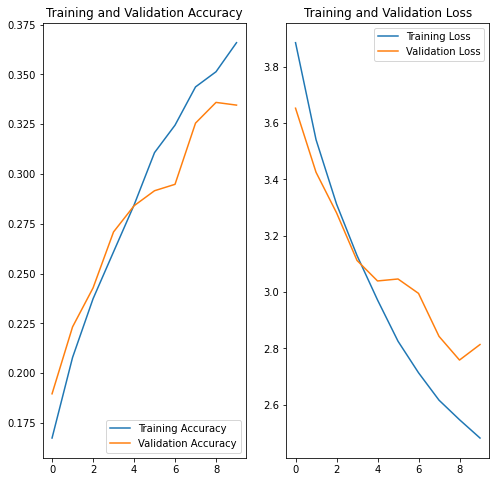

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()